We evaluate and compare the performance of the following anomaly detection methods:  
- Averaged localized p-value estimation (aK-LPE) method [1, 2]
- Local intrinsic dimensinality (LID) as a test statistic for anomaly detection [3, 4]

The nominal data is generated from a mixture of factor analyzers (MFA) model [5], which can generated high dimensional data having a low-dimensional latent structure. The anomalous data are generated by independently generating samples from each feature according to a normal or uniform distribution. 

The detection performance is evaluated as the dimension of the data is varied over a large range of values. We also compare the performance of Euclidean and Cosine distance metrics.

#### References
1. K-LPE method:   
Zhao, Manqi, and Venkatesh Saligrama. "Anomaly detection with score functions based on nearest neighbor graphs."
Advances in neural information processing systems. 2009.

1. Averaged K-LPE method:    
Qian, Jing, and Venkatesh Saligrama. "New statistic in p-value estimation for anomaly detection."
IEEE Statistical Signal Processing Workshop (SSP). IEEE, 2012.

1. Amsaleg, Laurent, et al. "Estimating local intrinsic dimensionality." Proceedings of the 21th ACM SIGKDD
International Conference on Knowledge Discovery and Data Mining. ACM, 2015.

1. Ma, Xingjun, et al. "Characterizing adversarial subspaces using local intrinsic dimensionality."
arXiv preprint arXiv:1801.02613 (2018).

1. McLachlan, Geoffrey J., David Peel, and R. W. Bean. "Modelling high-dimensional data by mixtures of factor analyzers." Computational Statistics & Data Analysis 41.3-4 (2003): 379-388.

In [1]:
import numpy as np
from multiprocessing import cpu_count
from localized_pvalue_estimation import averaged_KLPE_anomaly_detection
from lid_based_anomaly_detection import LID_based_anomaly_detection
from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve
)
from utils import (
    wrapper_data_generate, 
    metrics_detection
)
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define some constants
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'euclidean'
shared_nearest_neighbors = False

# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.4

max_fpr_pauc = 0.01

COLORS = ['r', 'b', 'g', 'c', 'orange', 'm', 'lawngreen', 'gold', 'y', 'hotpink']

In [3]:
# Generate data according to a mixture of factor analysis (MFA) model
np.random.seed(seed_rng)

# number of mixture components
n_components = 10
# dimension of the observed space
dim = 100
# Specify a range for the latent dimension
dim_latent_range = (20, 30)

# Number of training points, test points, and proportion of anomalies in the test data
N = 5000
N_test = 1000
prop_anomaly = 0.1

data, data_test, labels_test = wrapper_data_generate(dim, dim_latent_range, n_components, 
                                                     N, N_test, prop_anomaly=prop_anomaly, 
                                                     anom_type='gaussian', seed_rng=seed_rng)

In [4]:
# aK-LPE method
# Initialize the AD model
detector_lpe = averaged_KLPE_anomaly_detection(
    neighborhood_constant=neighborhood_constant, 
    n_neighbors=None, 
    metric=metric_primary, 
    metric_kwargs=None,
    shared_nearest_neighbors=shared_nearest_neighbors, 
    approx_nearest_neighbors=True,
    n_jobs=n_jobs, 
    seed_rng=seed_rng
)

# Fit the AD model to the nominal training data
detector_lpe.fit(data)

# Calculate the anomaly score of the test data
scores_test_lpe = detector_lpe.score(data_test)

In [5]:
# LID method
# Initialize the AD model
detector_lid = LID_based_anomaly_detection(
    neighborhood_constant=neighborhood_constant, 
    n_neighbors=None, 
    metric=metric_primary, 
    metric_kwargs=None, 
    approx_nearest_neighbors=True,
    n_jobs=n_jobs, 
    seed_rng=seed_rng
)

# Fit the AD model to the nominal training data
detector_lid.fit(data)

# Calculate the anomaly score of the test data
scores_test_lid = detector_lid.score(data_test)

In [6]:
# Calculate performance metrics
print("Performance of the aK-LPE method:")
au_roc1, au_roc_partial1, avg_prec1, tpr_spec1, fpr_spec1 = metrics_detection(
    scores_test_lpe, labels_test, pos_label=1, max_fpr=max_fpr_pauc, verbose=True
)

Performance of the aK-LPE method:
Area under the ROC curve = 0.999517
Partial area under the ROC curve (FPR <= 0.01) = 0.977387
Average precision = 0.995784

TPR, FPR
0.920000, 0.001111
0.960000, 0.006667
0.970000, 0.010000
1.000000, 0.052222
1.000000, 0.108889


In [7]:
print("Performance of the LID method:")
au_roc2, au_roc_partial2, avg_prec2, tpr_spec2, fpr_spec2 = metrics_detection(
    scores_test_lid, labels_test, pos_label=1, max_fpr=max_fpr_pauc, verbose=True
)

Performance of the LID method:
Area under the ROC curve = 1.000000
Partial area under the ROC curve (FPR <= 0.01) = 1.000000
Average precision = 1.000000

TPR, FPR
1.000000, 0.005556
1.000000, 0.005556
1.000000, 0.010000
1.000000, 0.050000
1.000000, 0.123333


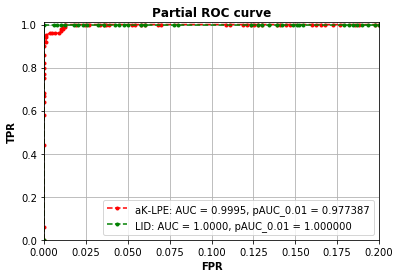

In [8]:
# ROC curve
fpr_arr1, tpr_arr1, _ = roc_curve(labels_test, scores_test_lpe, pos_label=1)
fpr_arr2, tpr_arr2, _ = roc_curve(labels_test, scores_test_lid, pos_label=1)

fig = plt.figure()
ls = "aK-LPE: AUC = {:.4f}, pAUC_{:.2f} = {:.6f}".format(au_roc1, max_fpr_pauc, au_roc_partial1)
plt.plot(fpr_arr1, tpr_arr1, linestyle='--', color='r', marker='.', label=ls)

ls = "LID: AUC = {:.4f}, pAUC_{:.2f} = {:.6f}".format(au_roc2, max_fpr_pauc, au_roc_partial2)
plt.plot(fpr_arr2, tpr_arr2, linestyle='--', color='g', marker='.', label=ls)

plt.xlabel('FPR', fontweight='bold')
plt.ylabel('TPR', fontweight='bold')
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 1.01])
plt.title('Partial ROC curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

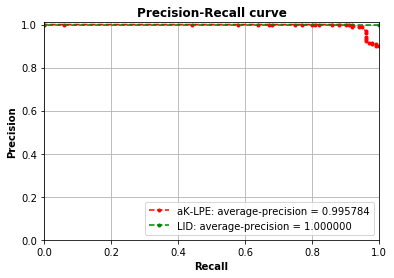

In [9]:
# Precision-Recall curve
precision_arr1, recall_arr1, _ = precision_recall_curve(labels_test, scores_test_lpe, pos_label=1)
precision_arr2, recall_arr2, _ = precision_recall_curve(labels_test, scores_test_lid, pos_label=1)

fig = plt.figure()
ls = "aK-LPE: average-precision = {:.6f}".format(avg_prec1)
plt.plot(recall_arr1, precision_arr1, linestyle='--', color='r', marker='.', label=ls)

ls = "LID: average-precision = {:.6f}".format(avg_prec2)
plt.plot(recall_arr2, precision_arr2, linestyle='--', color='g', marker='.', label=ls)

plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Precision-Recall curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Detection performance as a function of data dimension
Next, we evaluate the performance of the AD methods as the dimensionality of the data is varied over a large range. We evaluate both the euclidean and cosine distance metrics in order to assess their robustness to high dimensional data. Although the observed dimension of the data is increased, the latent dimension of the MFA model is kept the same.

In [10]:
# number of mixture components
n_components = 10

# The range of the latent dimension is kept fixed
dim_latent_range = (20, 45)

# Number of training points, test points, and proportion of anomalies in the test data
N = 5000
N_test = 1000
prop_anomaly = 0.1

# Performance metrics are averaged over a number of data sets
num_data_sets = 20

# dimension of the observed space
dim_range = np.concatenate([[50], np.arange(100, 1001, 100), [5000, 10000]])

In [11]:
method_metric_list = [('aK-LPE', 'euclidean'), ('aK-LPE', 'cosine'), ('LID', 'euclidean'), ('LID', 'cosine')]
num = len(method_metric_list)
perf_dict = {k: [] for k in method_metric_list}
for dim in dim_range:
    print("dim = {:d}".format(dim))
    au_roc = np.zeros(num)
    au_roc_partial = np.zeros(num)
    avg_prec = np.zeros(num)
    for t in range(num_data_sets):
        seed_rng = np.random.randint(1, high=10000)
        # Generate data
        data, data_test, labels_test = wrapper_data_generate(dim, dim_latent_range, n_components, 
                                                             N, N_test, prop_anomaly=prop_anomaly, 
                                                             anom_type='gaussian', seed_rng=seed_rng)
        j = 0
        for meth, metr in method_metric_list:
            # Initialize the AD model
            if meth == 'aK-LPE':
                detector = averaged_KLPE_anomaly_detection(
                    neighborhood_constant=neighborhood_constant, 
                    n_neighbors=None, 
                    metric=metr, 
                    metric_kwargs=None,
                    shared_nearest_neighbors=shared_nearest_neighbors, 
                    approx_nearest_neighbors=True,
                    n_jobs=n_jobs, 
                    seed_rng=seed_rng
                )
            else:
                detector = LID_based_anomaly_detection(
                    neighborhood_constant=neighborhood_constant, 
                    n_neighbors=None, 
                    metric=metr, 
                    metric_kwargs=None, 
                    approx_nearest_neighbors=True,
                    n_jobs=n_jobs, 
                    seed_rng=seed_rng
                )
                
            # Fit the AD model to the nominal training data
            detector.fit(data)
            
            # Calculate the anomaly score of the test data
            scores_test = detector.score(data_test)

            # performance metrics
            au_roc_curr, au_roc_partial_curr, avg_prec_curr, _, _ = metrics_detection(
                scores_test, labels_test, pos_label=1, max_fpr=max_fpr_pauc, verbose=False
            )
            au_roc[j] += au_roc_curr
            au_roc_partial[j] += au_roc_partial_curr
            avg_prec[j] += avg_prec_curr
            j += 1
            
    au_roc = au_roc / num_data_sets
    au_roc_partial = au_roc_partial / num_data_sets
    avg_prec = avg_prec / num_data_sets
    for j, tup in enumerate(method_metric_list):
        perf_dict[tup].append((au_roc[j], au_roc_partial[j], avg_prec[j]))


dim = 50
dim = 100
dim = 200
dim = 300
dim = 400
dim = 500
dim = 600
dim = 700
dim = 800
dim = 900
dim = 1000
dim = 5000
dim = 10000


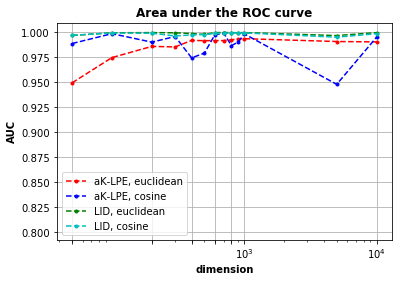

In [20]:
# Area under ROC as a function of dimension
fig = plt.figure()
y_min = 2.0
y_max = -1.0
for j, tup in enumerate(method_metric_list):
    vals = [v[0] for v in perf_dict[tup]]
    lab = '{}, {}'.format(tup[0], tup[1])
    plt.plot(dim_range, vals, linestyle='--', color=COLORS[j], marker='.', label=lab)
    
    a = min(vals)
    b = max(vals)
    if a < y_min:
        y_min = a
        
    if b > y_max:
        y_max = b

y_min = 0.99 * min(y_min, 0.8)
y_max = 1.01 * max(y_max, 0.9)
plt.xlabel('dimension', fontweight='bold')
plt.ylabel('AUC', fontweight='bold')
plt.ylim([y_min, y_max])
plt.xscale('log')
plt.xticks(dim_range[::2])
plt.title('Area under the ROC curve', fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

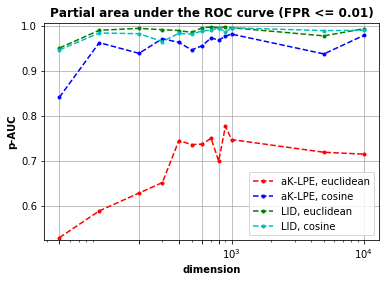

In [21]:
# Partial area under ROC as a function of dimension
fig = plt.figure()
y_min = 2.0
y_max = -1.0
for j, tup in enumerate(method_metric_list):
    vals = [v[1] for v in perf_dict[tup]]
    lab = '{}, {}'.format(tup[0], tup[1])
    plt.plot(dim_range, vals, linestyle='--', color=COLORS[j], marker='.', label=lab)
    
    a = min(vals)
    b = max(vals)
    if a < y_min:
        y_min = a
        
    if b > y_max:
        y_max = b

y_min = 0.99 * min(y_min, 0.8)
y_max = 1.01 * max(y_max, 0.9)
plt.xlabel('dimension', fontweight='bold')
plt.ylabel('p-AUC', fontweight='bold')
plt.ylim([y_min, y_max])
plt.xscale('log')
plt.xticks(dim_range[::2])
plt.title('Partial area under the ROC curve (FPR <= {:.2f})'.format(max_fpr_pauc), fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

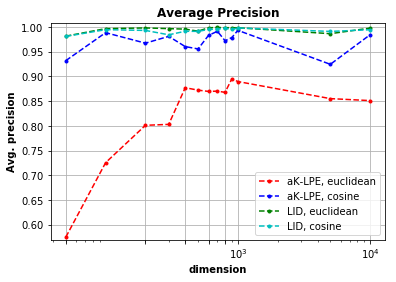

In [22]:
# Average precision as a function of dimension
fig = plt.figure()
y_min = 2.0
y_max = -1.0
for j, tup in enumerate(method_metric_list):
    vals = [v[2] for v in perf_dict[tup]]
    lab = '{}, {}'.format(tup[0], tup[1])
    plt.plot(dim_range, vals, linestyle='--', color=COLORS[j], marker='.', label=lab)
    
    a = min(vals)
    b = max(vals)
    if a < y_min:
        y_min = a
        
    if b > y_max:
        y_max = b

y_min = 0.99 * min(y_min, 0.8)
y_max = 1.01 * max(y_max, 0.9)
plt.xlabel('dimension', fontweight='bold')
plt.ylabel('Avg. precision', fontweight='bold')
plt.ylim([y_min, y_max])
plt.xscale('log')
plt.xticks(dim_range[::2])
plt.title('Average Precision', fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()